# Exercice 1 - NACA 4412

## Experimental data
Les données du graphique page 136 ont été numérisées. On peut les tracer pour vérifier, l'option retina c'est pour améliorer la qualité des tracés de ce notebook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

In [2]:
data_cl = np.loadtxt('NACA4412_polar_cl.csv',skiprows=1,delimiter=',',usecols=(1,0))
data_cm = np.loadtxt('NACA4412_Cmc4_CL.csv',skiprows=1,delimiter=',')

Mes extractions sont un peu bruitées, on va prendre une interpolation linéaire du coefficient du $c_l$ et sur $c_{m,c/4}$ selon des droites entre $[-10,12]$ degrés. On a montré par la théorie que c'était le cas pour $c_l$ avec la théorie des profils minces. Pour le $c_{m,c/4}$ on obtient une constante (qui dépend de la cambrure) avec la théorie des profils minces, mais on a une variation (faible) mesurée expérimentalement.

In [3]:
# Cl linear fit
aoa_keep = (data_cl[:,0] >= -10) * (data_cl[:,0] <= 12) # restriction of the linear domain
p_cl = np.polyfit(data_cl[aoa_keep,0],data_cl[aoa_keep,1],1)
cl_intp_fct = np.poly1d(p_cl)
p_cm = np.polyfit(data_cm[:,0],data_cm[:,1],1)
cm_intp_fct = np.poly1d(p_cm)

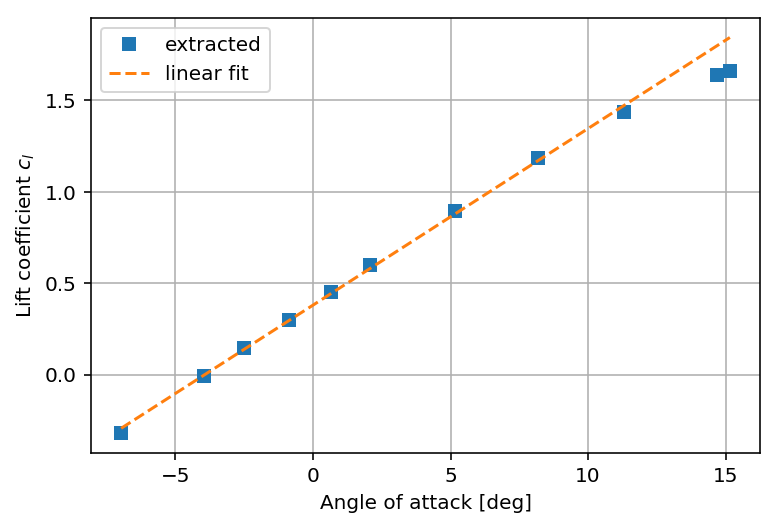

In [4]:
plt.plot(data_cl[:,0],data_cl[:,1],'s',label='extracted');
plt.plot(data_cl[:,0],cl_intp_fct(data_cl[:,0]),label='linear fit',linestyle='dashed')
plt.xlabel('Angle of attack [deg]');
plt.ylabel('Lift coefficient $c_l$');
plt.grid();
plt.legend();
plt.savefig('coeff_cl_interp.png');

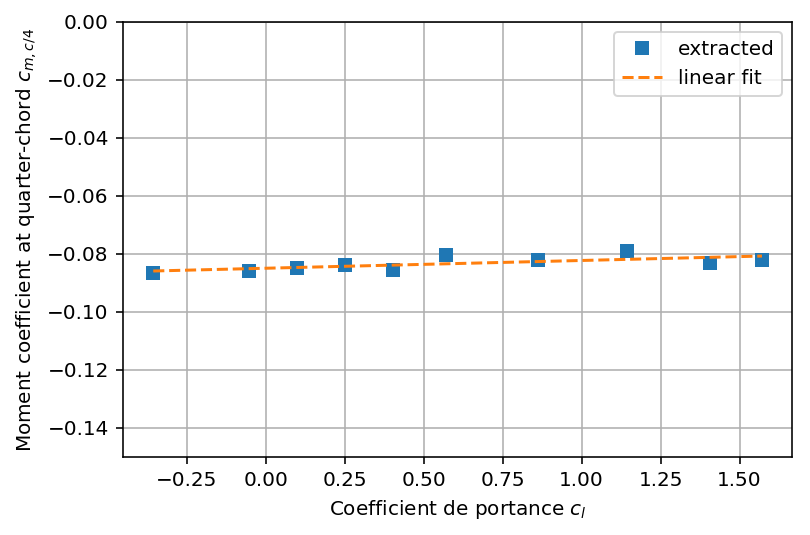

In [5]:
plt.plot(data_cm[:,0],data_cm[:,1],'s',label='extracted');
plt.plot(data_cm[:,0],cm_intp_fct(data_cm[:,0]),label='linear fit',linestyle='dashed');
plt.xlabel('Coefficient de portance $c_l$');
plt.ylabel('Moment coefficient at quarter-chord $c_{m,c/4}$');
plt.ylim(-0.15,0.0);
plt.grid();
plt.legend();
plt.savefig('coeff_cm_cl.png');

In [25]:
print('Coefficient de portance à 3 deg: {0:.4f}'.format(cl_intp_fct(3.)))
print('Coefficient de moment au quart de corde à cl(3°): {0:.4f}'.format(cm_intp_fct(cl_intp_fct(3.))))

Coefficient de portance à 3 deg: 0.6707
Coefficient de moment au quart de corde à cl(3°): -0.0832


On utilise le module de calcul symbolique `sympy` pour calculer les intégrales.

In [7]:
import sympy as sb
sb.init_printing()

In [8]:
theta = sb.Symbol('theta')
aoa   = sb.Symbol('alpha')

L'angle de Glauert qui correspond au raccordement entre les deux polynômes qui définissent $\frac{\eta_C}{c}$.

In [9]:
theta_c = np.arccos(0.2)
print('theta_c = {0:.3f} rad = {1:.2f} deg'.format(theta_c,theta_c*180./np.pi))

theta_c = 1.369 rad = 78.46 deg


On définit la dérivée de $\frac{d\eta_C}{dx}$ que l'on voudra intégrer pour obtenir les $A_i$.

In [10]:
xc = 0.5*(1-sb.cos(theta))
pente_C_piece1 = 0.25 * (0.8-2*xc)
pente_C_piece1

In [11]:
pente_C_piece2 = 0.111*(0.8-2*xc)
pente_C_piece2

On calcule $A_0$

In [12]:
A0=aoa -1/sb.pi * (sb.integrate(pente_C_piece1,(theta,0,theta_c))+sb.integrate(pente_C_piece2,(theta,theta_c,sb.pi)))
sb.N(A0)

On calcule $A_1$

In [13]:
A1 = 2/sb.pi *(sb.integrate(pente_C_piece1 * sb.cos(theta),(theta,0,theta_c)) + sb.integrate(pente_C_piece2 * sb.cos(theta),(theta,theta_c,sb.pi)))
sb.N(A1)

On évalue pour avoir l'abscisse $A_0+A_1/2=\alpha -\alpha_{L=0}$.

In [14]:
sb.N((A0+A1/2))

In [15]:
np.rad2deg(-0.0724273763371431)

On a obtenu des valeurs expérimentales extraites $\alpha_{L=0}$ directement en degrés : 

In [16]:
-(p_cl[1]/p_cl[0])

Comparons la pente de la théorie avec la valeur reportée au tableau p56 du rapport NACA 460.

In [17]:
print('pente theorique m0={0:.3f} [1/rad]'.format(sb.N(2*sb.pi)))
print('pente donnee NACA m0={0:.3f} [1/rad]'.format(sb.N(0.100*180/sb.pi)))
print('pente donnee NACA interpolee m0={0:.3f} [1/rad]'.format(p_cl[0]*180/np.pi))

pente theorique m0=6.283 [1/rad]
pente donnee NACA m0=5.730 [1/rad]
pente donnee NACA interpolee m0=5.532 [1/rad]


Il y a une différence importante. On vérifie la précision du résultat obtenu graphiquement.

In [18]:
cl = 2* sb.pi * (A0+A1/2)
cl_theorical = sb.lambdify(aoa,cl,'numpy')

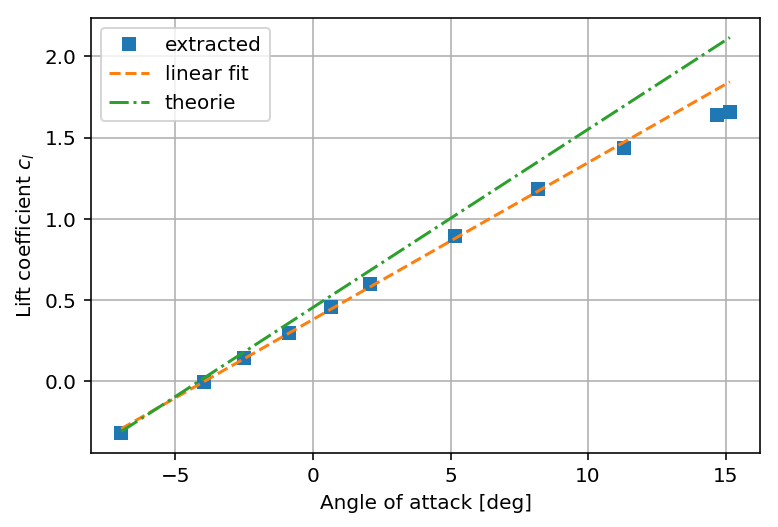

In [19]:
plt.plot(data_cl[:,0],data_cl[:,1],'s',label='extracted');
plt.plot(data_cl[:,0],cl_intp_fct(data_cl[:,0]),label='linear fit',linestyle='dashed')
plt.plot(data_cl[:,0],cl_theorical(np.deg2rad(data_cl[:,0])),label='theorie',linestyle='-.')
plt.xlabel('Angle of attack [deg]');
plt.ylabel('Lift coefficient $c_l$');
plt.grid();
plt.legend();
plt.savefig('coeff_cl_interp.png',dpi=300);

Graphiquement on retrouve que la pente théorique est plus importante que la pente expérimentale.

$c_L$ à $3^\circ$

In [20]:
print('cl theorique a 3 deg: {0:.4f}'.format(cl_theorical(3*np.pi/180.)))
print('cl mesure par la NACA a 3 deg: {0:.4f}'.format( cl_intp_fct(3.)))

cl theorique a 3 deg: 0.7841
cl mesure par la NACA a 3 deg: 0.6707


In [21]:
A2 = 2/sb.pi *(sb.integrate(pente_C_piece1 * sb.cos(2.*theta),(theta,0,theta_c)) + sb.integrate(pente_C_piece2 * sb.cos(2.*theta),(theta,theta_c,sb.pi)))
sb.N(A2)

In [22]:
cm_theorie_c_14 = sb.pi /4* (A2-A1)
print('theorie: cm quart de corde a 3deg: {0:.4f}'.format(sb.N(cm_theorie_c_14)));
print('donnees naca: cm quart de corde a 3deg: {0:.4f}'.format(cm_intp_fct(cl_intp_fct(3.))));

theorie: cm quart de corde a 3deg: -0.1062
donnees naca: cm quart de corde a 3deg: -0.0832


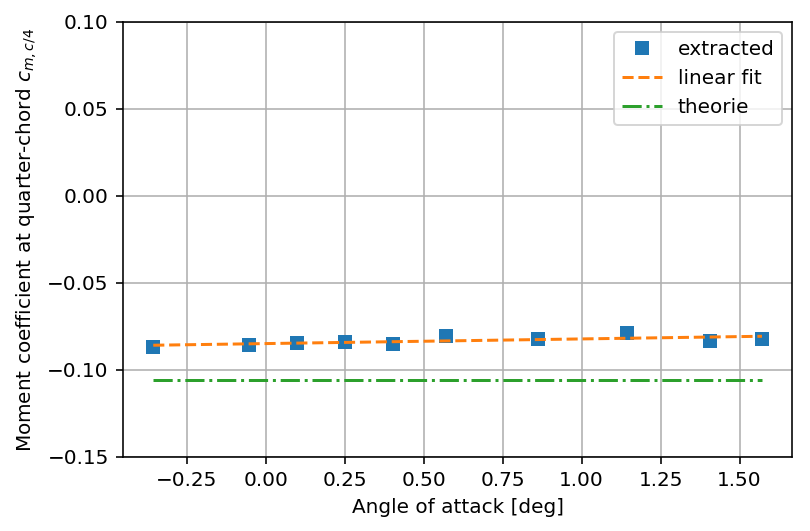

In [23]:
plt.plot(data_cm[:,0],data_cm[:,1],'s',label='extracted');
plt.plot(data_cm[:,0],cm_intp_fct(data_cm[:,0]),label='linear fit',linestyle='dashed')
plt.plot(data_cm[:,0],cm_theorie_c_14*np.ones_like(data_cm[:,0]),label='theorie',linestyle='-.')
plt.xlabel('Angle of attack [deg]');
plt.ylabel('Moment coefficient at quarter-chord $c_{m,c/4}$');
plt.ylim(-0.15,0.1);
plt.grid();
plt.legend();
plt.savefig('coeff_cm_interp.png');

Le coefficient de moment théorique est plus faible que le coefficient de moment mesuré.

Pente de l'aile d'envergure finie

In [34]:
AR         = 8
tau        = 0.05
delta      = 0.05
e          = 1/(1+delta)
# resultats precedents
m0_th      = 2*np.pi
alfa_L0_th = -0.0724 
# extractions precedentes
m0_naca = p_cl[0]*180/np.pi
alfa_L0_naca = -(p_cl[1]/p_cl[0]) * np.pi/180.

In [30]:
m_th = m0_th / (1+ m0_th / (np.pi *AR) * (1+tau))
m_naca = m0_naca / (1+ m0_naca / (np.pi *AR) * (1+tau))
print('Theorie : Pente aile AR={0:.1f} : m={1:.3f}'.format(AR,m_th))
print('NACA : Pente aile AR={0:.1f} : m={1:.3f}'.format(AR,m_naca))

Theorie : Pente aile AR=8.0 : m=4.977
NACA : Pente aile AR=8.0 : m=4.493


In [32]:
CL_th = m_th*(np.deg2rad(3.)-alfa_L0_th)
CL_naca = m_naca*(np.deg2rad(3.)-alfa_L0_naca)
print('Theorie (aile AR={0:.1f}) : CL(3 deg)={1:.3f}'.format(AR,CL_th))
print('NACA (aile AR={0:.1f}) : CL(3 deg)={1:.3f}'.format(AR,CL_naca))

Theorie (aile AR=8.0) : CL(3 deg)=0.621
NACA (aile AR=8.0) : CL(3 deg)=0.545


In [36]:
CDi_th = CL_th**2 /(np.pi * AR * e)
CDi_naca = CL_naca**2 /(np.pi * AR * e)
print('Theorie (aile AR={0:.1f}) : CDi(3 deg)={1:.3f}'.format(AR,CDi_th))
print('NACA (aile AR={0:.1f}) : CDi(3 deg)={1:.3f}'.format(AR,CDi_naca))

Theorie (aile AR=8.0) : CDi(3 deg)=0.016
NACA (aile AR=8.0) : CDi(3 deg)=0.012
